In [1]:
# settings for testing and running on a PC.
from glob import glob
from polyphys.manage import organizer
from polyphys.manage.parser import SumRule, TransFoci
from polyphys.probe import prober

#### segment all trjs for hist_dd

In [37]:
from typing import Optional
from typing import Callable, Optional, Tuple, Dict, Type
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
import numpy as np
import pandas as pd
import os
from polyphys.manage.parser import SumRule, TransFoci
from polyphys.manage.organizer import invalid_keyword
from polyphys.analyze import clusters
import warnings

In [ ]:
%%time
# 4 mins for ~4000 particles with one all trj
# macbookmini
parent = "/Users/amirhsi_mini/research_data/trjs"
# macbookpro
#parent = "/Users/amirhsi/Downloads/N2000epsilon5.0r15.5lz379.5sig6.0nc1779dt0.005bdump1000adump5000ens7"
geometry = 'biaxial'
group = 'all'
topo_lineage = 'whole'
continuous = True
lineage = 'segment'
save_to = './'
all_trjs = glob(parent + '/N*' + group + '*')
all_trjs = organizer.sort_filenames(
    all_trjs,
    fmts=['.' + group + '.lammpstrj']
)
all_trjs = [all_trj[0] for all_trj in all_trjs]
print(all_trjs)
all_topo = glob(parent + '/N*' + group + '*')
print(all_topo)
all_topo = organizer.sort_filenames(all_topo, fmts=['.' + group + '.data'])
all_topo = all_topo[0][0]
max_segment_id = len(all_trjs)
# analyzig all files
# it is assumed that the all trjs are numbers from 1 to max_segment_id
for all_trj in all_trjs:
    trj_info = SumRule(
        all_trj,
        geometry=geometry,
        group=group,
        lineage=topo_lineage
    )
    trajectory = all_trj
    topology = all_topo
    if (lineage == 'segment') & (continuous is False):
        print(
            "lineage is "
            f"'{lineage}' "
            "and 'continuous' is "
            f"'{continuous}. "
            "Please ensure the "
            f"'{trajectory}' is NOT part of a sequence of trajectories.")
    print("Setting the name of analyze file...\n")
    sim_info = SumRule(
        trajectory,
        geometry,
        'all',
        lineage
    )
    sim_name = sim_info.lineage_name + "-" + sim_info.group
    print("\n" + sim_name + " is analyzing...")
    # dict of bin edges:
    bin_edges = {
        'xEdge': {
            'bin_size':  0.1 * min(sim_info.dmon, sim_info.dcrowd),
            'lmin': -0.5 * sim_info.dcyl,
            'lmax': 0.5 * sim_info.dcyl
            },
        'yEdge': {
            'bin_size':  0.1 * min(sim_info.dmon, sim_info.dcrowd),
            'lmin': -0.5 * sim_info.dcyl,
            'lmax': 0.5 * sim_info.dcyl
            },
        'zEdge': {
            'bin_size':  0.5 * min(sim_info.dmon, sim_info.dcrowd),
            'lmin': -0.5 * sim_info.lcyl,
            'lmax': 0.5 * sim_info.lcyl
            }
        }
    # LJ time difference between two consecutive frames:
    time_unit = \
        sim_info.dmon * np.sqrt(sim_info.mmon * sim_info.eps_others)
    lj_nstep = sim_info.adump  # Sampling steps via dump command in Lammps
    lj_dt = sim_info.dt
    sim_real_dt = lj_nstep * lj_dt * time_unit
    cell = mda.Universe(
        topology,
        trajectory,
        topology_format='DATA',
        format='LAMMPSDUMP',
        lammps_coordinate_convention='unscaled',
        atom_style="id resid type x y z",
        dt=sim_real_dt
    )
    # slicing trajectory based the continuous condition
    if continuous:
        sliced_trj = cell.trajectory[0: -1]
    else:
        sliced_trj = cell.trajectory
    # selecting atom groups
    crds = cell.select_atoms('resid 0')  # crowders
    bug = cell.select_atoms('resid 1')  # the chain or monomers
    # bin edges and histograms in different directions:
    # x direction of the cartesian coordinate system
    x_hist_info = prober.fixedsize_bins(
        sim_name,
        'xEdge',
        bin_edges['xEdge']['bin_size'],
        bin_edges['xEdge']['lmin'],
        bin_edges['xEdge']['lmax'],
        bin_type='ordinary',
        save_to=save_to
    )
    # y direction of the cartesian coordinate system
    y_hist_info = prober.fixedsize_bins(
        sim_name,
        'yEdge',
        bin_edges['yEdge']['bin_size'],
        bin_edges['yEdge']['lmin'],
        bin_edges['yEdge']['lmax'],
        bin_type='ordinary',
        save_to=save_to
    )
    # z direction of the cartesian coordinate system
    z_hist_info = prober.fixedsize_bins(
        sim_name,
        'zEdge',
        bin_edges['zEdge']['bin_size'],
        bin_edges['zEdge']['lmin'],
        bin_edges['zEdge']['lmax'],
        bin_type='ordinary',
        save_to=save_to
    )
    # check if any of the histograms are empty or not.
    if any([
            x_hist_info['collector'].any() != 0,
            x_hist_info['collector_std'].any() != 0,
            y_hist_info['collector'].any() != 0,
            y_hist_info['collector_std'].any() != 0,
            z_hist_info['collector'].any() != 0,
            z_hist_info['collector_std'].any() != 0,
            ]):
        raise ValueError(
            "One of the histogram collectors is not empty!")
    # 2D hists
    # crd
    # xy
    hist_crd_info_xy = {
        'n_bins': (
            x_hist_info['n_bins'],
            y_hist_info['n_bins']
        ),
        'bin_edges': [
            x_hist_info['bin_edges'],
            y_hist_info['bin_edges']
        ],
        'range':[
            x_hist_info['range'],
            y_hist_info['range']
        ] 
    }
    hist_crd_info_xy['collector'] = np.zeros(hist_crd_info_xy['n_bins'])
    hist_crd_info_xy['collector'] *= 0
    #hist_crd_info_xy['collector_std'] = hist_crd_info_xy['collector'].copy()
    # xz
    hist_crd_info_xz = {
        'n_bins': (
            x_hist_info['n_bins'],
            z_hist_info['n_bins']
        ),
        'bin_edges': [
            x_hist_info['bin_edges'],
            z_hist_info['bin_edges']
        ],
        'range':[
            x_hist_info['range'],
            z_hist_info['range']
        ] 
    }
    hist_crd_info_xz['collector'] = np.zeros(hist_crd_info_xz['n_bins'])
    hist_crd_info_xz['collector'] *= 0
    #hist_crd_info_xz['collector_std'] = hist_crd_info_xz['collector'].copy()
    # yz
    hist_crd_info_yz = {
        'n_bins': (
            x_hist_info['n_bins'],
            z_hist_info['n_bins']
        ),
        'bin_edges': [
            x_hist_info['bin_edges'],
            z_hist_info['bin_edges']
        ],
        'range':[
            x_hist_info['range'],
            z_hist_info['range']
        ] 
    }
    hist_crd_info_yz['collector'] = np.zeros(hist_crd_info_yz['n_bins'])
    hist_crd_info_yz['collector'] *= 0
    #hist_crd_info_yz['collector_std'] = hist_crd_info_yz['collector'].copy()
    # mon
    # xy
    hist_mon_info_xy = {
        'n_bins': (
            x_hist_info['n_bins'],
            y_hist_info['n_bins']
        ),
        'bin_edges': [
            x_hist_info['bin_edges'],
            y_hist_info['bin_edges']
        ],
        'range':[
            x_hist_info['range'],
            y_hist_info['range']
        ] 
    }
    hist_mon_info_xy['collector'] = np.zeros(hist_mon_info_xy['n_bins'])
    hist_mon_info_xy['collector'] *= 0
    #hist_mon_info_xy['collector_std'] = hist_mon_info_xy['collector'].copy()
    # xz
    hist_mon_info_xz = {
        'n_bins': (
            x_hist_info['n_bins'],
            z_hist_info['n_bins']
        ),
        'bin_edges': [
            x_hist_info['bin_edges'],
            z_hist_info['bin_edges']
        ],
        'range':[
            x_hist_info['range'],
            z_hist_info['range']
        ] 
    }
    hist_mon_info_xz['collector'] = np.zeros(hist_mon_info_xz['n_bins'])
    hist_mon_info_xz['collector'] *= 0
    #hist_mon_info_xz['collector_std'] = hist_mon_info_xz['collector'].copy()
    # yz
    hist_mon_info_yz = {
        'n_bins': (
            x_hist_info['n_bins'],
            z_hist_info['n_bins']
        ),
        'bin_edges': [
            x_hist_info['bin_edges'],
            z_hist_info['bin_edges']
        ],
        'range':[
            x_hist_info['range'],
            z_hist_info['range']
        ] 
    }
    hist_mon_info_yz['collector'] = np.zeros(hist_mon_info_yz['n_bins'])
    hist_mon_info_yz['collector'] *= 0
    #hist_mon_info_yz['collector_std'] = hist_mon_info_yz['collector'].copy()
    for _ in sliced_trj:
        # histogram in 3 dimesional space
        # crds
        # xy
        frame_hist, _, _ = np.histogram2d(
            crds.positions[:,0],
            crds.positions[:,1],
            bins=hist_crd_info_xy['bin_edges'],  
            range=hist_crd_info_xy['range'],      
        )
        hist_crd_info_xy['collector'] += frame_hist
        #hist_crd_info_xy['collector_std'] += np.square(frame_hist)
        # xz
        frame_hist, _, _ = np.histogram2d(
            crds.positions[:,0],
            crds.positions[:,2],
            bins=hist_crd_info_xz['bin_edges'],  
            range=hist_crd_info_xz['range'],      
        )
        hist_crd_info_xz['collector'] += frame_hist
        #hist_crd_info_xz['collector_std'] += np.square(frame_hist)
        # yz
        frame_hist, _, _ = np.histogram2d(
            crds.positions[:,1],
            crds.positions[:,2],
            bins=hist_crd_info_yz['bin_edges'],  
            range=hist_crd_info_yz['range'],      
        )
        hist_crd_info_yz['collector'] += frame_hist
        #hist_crd_info_yz['collector_std'] += np.square(frame_hist)
        # bug
        # xy
        frame_hist, _, _ = np.histogram2d(
            bug.positions[:,0],
            bug.positions[:,1],
            bins=hist_mon_info_xy['bin_edges'],  
            range=hist_mon_info_xy['range'],      
        )
        hist_mon_info_xy['collector'] += frame_hist
        #hist_mon_info_xy['collector_std'] += np.square(frame_hist)
        # xz
        frame_hist, _, _ = np.histogram2d(
            bug.positions[:,0],
            bug.positions[:,2],
            bins=hist_mon_info_xz['bin_edges'],  
            range=hist_mon_info_xz['range'],      
        )
        hist_mon_info_xz['collector'] += frame_hist
        #hist_mon_info_xz['collector_std'] += np.square(frame_hist)
        # yz
        frame_hist, _, _ = np.histogram2d(
            bug.positions[:,1],
            bug.positions[:,2],
            bins=hist_mon_info_yz['bin_edges'],  
            range=hist_mon_info_yz['range'],      
        )
        hist_mon_info_yz['collector'] += frame_hist
        #hist_mon_info_yz['collector_std'] += np.square(frame_hist)

    lastname = 'Crd'
    np.save(
        save_to + sim_name + '-xyHist' + lastname + '.npy',
        hist_crd_info_xy['collector']
    )
    np.save(
        save_to + sim_name + '-xzHist' + lastname + '.npy',
        hist_crd_info_xz['collector']
    )
    np.save(
        save_to + sim_name + '-yzHist' + lastname + '.npy',
        hist_crd_info_yz['collector']
    )
    lastname = 'Mon'
    np.save(
        save_to + sim_name + '-xyHist' + lastname + '.npy',
        hist_mon_info_xy['collector']
    )
    np.save(
        save_to + sim_name + '-xzHist' + lastname + '.npy',
        hist_mon_info_xz['collector']
    )
    np.save(
        save_to + sim_name + '-yzHist' + lastname + '.npy',
        hist_mon_info_yz['collector']
    )
    print('done.')

In [52]:
%%time
# 4 mins for ~4000 particles with one all trj
# macbookmini
parent = "/Users/amirhsi_mini/research_data/trjs"
# macbookpro
#parent = "/Users/amirhsi/Downloads/N2000epsilon5.0r15.5lz379.5sig6.0nc1779dt0.005bdump1000adump5000ens7"
geometry = 'biaxial'
group = 'all'
topo_lineage = 'whole'
continuous = True
lineage = 'segment'
save_to = './'
all_trjs = glob(parent + '/N*' + group + '*')
all_trjs = organizer.sort_filenames(
    all_trjs,
    fmts=['.' + group + '.lammpstrj']
)
all_trjs = [all_trj[0] for all_trj in all_trjs]
print(all_trjs)
all_topo = glob(parent + '/N*' + group + '*')
print(all_topo)
all_topo = organizer.sort_filenames(all_topo, fmts=['.' + group + '.data'])
all_topo = all_topo[0][0]
max_segment_id = len(all_trjs)
# analyzig all files
# it is assumed that the all trjs are numbers from 1 to max_segment_id
for all_trj in all_trjs:
    trj_info = SumRule(
        all_trj,
        geometry=geometry,
        group=group,
        lineage=topo_lineage
    )
    trajectory = all_trj
    topology = all_topo
    if (lineage == 'segment') & (continuous is False):
        print(
            "lineage is "
            f"'{lineage}' "
            "and 'continuous' is "
            f"'{continuous}. "
            "Please ensure the "
            f"'{trajectory}' is NOT part of a sequence of trajectories.")
    print("Setting the name of analyze file...\n")
    sim_info = SumRule(
        trajectory,
        geometry,
        'all',
        lineage
    )
    sim_name = sim_info.lineage_name + "-" + sim_info.group
    print("\n" + sim_name + " is analyzing...")
    # dict of bin edges:
    bin_edges = {
        'xEdge': {
            'bin_size':  0.1 * min(sim_info.dmon, sim_info.dcrowd),
            'lmin': -0.5 * sim_info.dcyl,
            'lmax': 0.5 * sim_info.dcyl
            },
        'yEdge': {
            'bin_size':  0.1 * min(sim_info.dmon, sim_info.dcrowd),
            'lmin': -0.5 * sim_info.dcyl,
            'lmax': 0.5 * sim_info.dcyl
            },
        'zEdge': {
            'bin_size':  0.5 * min(sim_info.dmon, sim_info.dcrowd),
            'lmin': -0.5 * sim_info.lcyl,
            'lmax': 0.5 * sim_info.lcyl
            }
        }
    # LJ time difference between two consecutive frames:
    time_unit = \
        sim_info.dmon * np.sqrt(sim_info.mmon * sim_info.eps_others)
    lj_nstep = sim_info.adump  # Sampling steps via dump command in Lammps
    lj_dt = sim_info.dt
    sim_real_dt = lj_nstep * lj_dt * time_unit
    cell = mda.Universe(
        topology,
        trajectory,
        topology_format='DATA',
        format='LAMMPSDUMP',
        lammps_coordinate_convention='unscaled',
        atom_style="id resid type x y z",
        dt=sim_real_dt
    )
    # slicing trajectory based the continuous condition
    if continuous:
        sliced_trj = cell.trajectory[0: -1]
    else:
        sliced_trj = cell.trajectory
    # selecting atom groups
    bug = cell.select_atoms('resid 1')  # the chain or monomers
    
    #fsd_t = []
    #hist_mon_info_yz['collector_std'] = hist_mon_info_yz['collector'].copy()
    #for _ in sliced_trj:
    #    fsd_t.append(max(np.linalg.norm(bug.positions[:,:2],axis=1)))
    #_ = [fsd_t.append(max(np.linalg.norm(bug.positions[:,:2],axis=1))) for _ in sliced_trj]
    trans_size = AnalysisFromFunction(transverse_size, cell.trajectory, bug)
    trans_size.run(stop=-1)
    transverse_size = trans_size.results['timeseries']
    print('done.')

['/Users/amirhsi_mini/research_data/trjs/N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01.all.lammpstrj']
['/Users/amirhsi_mini/research_data/trjs/N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01.all.lammpstrj', '/Users/amirhsi_mini/research_data/trjs/N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.all.data']
Setting the name of analyze file...


N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all is analyzing...
done.
CPU times: user 2min 1s, sys: 1 s, total: 2min 2s
Wall time: 2min 3s


In [55]:
len(cell.trajectory)

14001

In [53]:
len(trans_size.results['timeseries'])

14000

In [45]:
def transverse_size(atomgroup):
    # calculation in the center of geometry of the atom group.
    # coordinates change for each frame
    transverse_pos = atomgroup.positions[:,:2] # x,y not z
    transverse_pos = transverse_pos - np.mean(transverse_pos, axis=0)
    # times by 2, so we have the diameter not radius:
    return 2 * max(np.linalg.norm(transverse_pos,axis=1))

In [29]:
fsd_t = np.array(fsd_t)

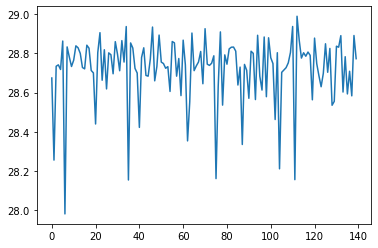

In [51]:
plt.plot(2*fsd_t[::100])

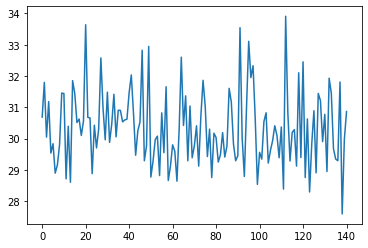

In [50]:
plt.plot(trans_size.results['timeseries'][::100])

### Visualizing

In [20]:
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import seaborn as sns

In [ ]:
yedges.max()

In [ ]:
xedges = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-xEdge.npy')
yedges = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-yEdge.npy')
zedges = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-zEdge.npy')
xcenters = (xedges[:-1] + xedges[1:]) / 2
xcenters = xcenters / xcenters.max()
ycenters = (yedges[:-1] + yedges[1:]) / 2
ycenters = ycenters / ycenters.max()
zcenters = (zedges[:-1] + zedges[1:]) / 2
zcenters = zcenters / zcenters.max()

In [ ]:
hist_xy_mon = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-xyHistMon.npy')
hist_xy_mon = hist_xy_mon / hist_xy_mon.sum()

hist_xz_mon = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-xzHistMon.npy')
hist_yz_mon = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-yzHistMon.npy')
hist_trans_mon = (hist_xz_mon + hist_yz_mon) * 0.5
hist_trans_mon = hist_trans_mon / hist_trans_mon.sum()

hist_xy_crd = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-xyHistCrd.npy')
hist_xy_crd = hist_xy_crd / hist_xy_crd.sum()
hist_xz_crd = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-xzHistCrd.npy')
hist_yz_crd = np.load('N2000epsilon5.0r15.5lz379.5sig4.0nc3203dt0.005bdump1000adump5000ens7.j01-all-yzHistCrd.npy')
hist_trans_crd = (hist_xz_crd + hist_yz_crd ) * 0.5
hist_trans_crd = hist_trans_crd / hist_trans_crd.sum()

In [ ]:
z_cut = 0.5
z_mask = (zcenters >= -z_cut) & (zcenters <= z_cut) 
zcenters_cut = zcenters[z_mask]
hist_xz_crd_cut = hist_xz_crd[:,z_mask]
hist_yz_crd_cut = hist_yz_crd[:,z_mask]
hist_xz_mon_cut = hist_xz_mon[:,z_mask]
hist_yz_mon_cut = hist_yz_mon[:,z_mask]

#### Sub-figure

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm
import seaborn as sns
#flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
cmap = sns.color_palette("rocket_r", as_cmap=True)
rc_params = {
        'axes.facecolor': 'white',
        'mathtext.default': 'regular',
        'text.usetex': True,
        'axes.grid': False,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both'
        }
phi_c_bulk_round = 0.2
nmon= 2000
dcyl = 30.0
dcrowd= 4.0
ext = 'pdf'
save_to = './'
output = 'SumRule-hist2d'
#with mpl.rc_context(rc_params):
sns.set_theme(
        context='paper',
        style='ticks',
        font='Times New Roman',
        font_scale=1.6,
        rc=rc_params
    )
interp = 'bilinear'
fig = plt.figure(constrained_layout=True, figsize=(22, 11))
fig.suptitle(fr"$N={nmon}, {{D}}/{{a_s}}={dcyl}, {{a_c}}/{{a_s}}={dcrowd}, \phi_c={phi_c_bulk_round}$", )
colfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[3, 1.2])
# left fig
leftfig = colfigs[0]
axes = leftfig.subplots(ncols=1, nrows=4, sharex=True)
# xz
# crd
ax = axes[0]
rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
            edgecolor='black', linewidth=1, alpha=1, zorder=1)
ax.add_patch(rectangle)
im = NonUniformImage(
    ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1), cmap=cmap)
im.set_data(zcenters_cut, xcenters, hist_xz_crd_cut)
im.set(clip_path=rectangle, clip_on=True)
ax.add_image(im)
ax.set_xlim(-z_cut, z_cut)
ax.set_ylim(-1.1, 1.1)
#ax.set_xlabel(r"$z/z_{max}$")
ax.set_ylabel(r"$2x/D$")
ax.set_title(r"$\rho_c(x,z)$")
# mon
ax = axes[1]
rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
            edgecolor='black', linewidth=1, alpha=1, zorder=1)
ax.add_patch(rectangle)
im = NonUniformImage(
    ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                     cmap=cmap)
im.set_data(zcenters_cut, xcenters, hist_xz_mon_cut)
im.set(clip_path=rectangle, clip_on=True)
ax.add_image(im)
ax.set_xlim(-z_cut, z_cut)
ax.set_ylim(-1.1, 1.1)
#ax.set_xlabel(r"$z/z_{max}$")
ax.set_ylabel(r"$2x/D$")
ax.set_title(r"$\rho_m(x,z)$")
# yz
# crd
ax = axes[2]
rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
            edgecolor='black', linewidth=1, alpha=1, zorder=1)
ax.add_patch(rectangle)
im = NonUniformImage(
    ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                     cmap=cmap)
im.set_data(zcenters_cut, ycenters, hist_yz_crd_cut)
im.set(clip_path=rectangle, clip_on=True)
ax.add_image(im)
ax.set_xlim(-z_cut, z_cut)
ax.set_ylim(-1.1, 1.1)
#ax.set_xlabel(r"$z/z_{max}$")
ax.set_ylabel(r"$2y/D$")
ax.set_title(r"$\rho_c(y,z)$")
# mon
ax = axes[3]
rectangle = plt.Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
            edgecolor='black', linewidth=1, alpha=1, zorder=1)
ax.add_patch(rectangle)
im = NonUniformImage(
    ax, interpolation=interp, extent=(-z_cut, z_cut, -1, 1),
                     cmap=cmap)
im.set_data(zcenters_cut, ycenters, hist_yz_mon_cut)
im.set(clip_path=rectangle, clip_on=True)
ax.add_image(im)
ax.set_xlim(-z_cut, z_cut)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel(r"$z/z_{max}$")
ax.set_ylabel(r"$2y/D$")
ax.set_title(r"$\rho_m(y,z)$")
# right fig
rightfig = colfigs[1]
axes = rightfig.subplots(ncols=1, nrows=2, sharex=True)
# crd
ax = axes[0]
circle = Circle((0, 0),1, facecolor='none',
            edgecolor='black', linewidth=1, alpha=1, zorder=1)
ax.add_patch(circle)
im = NonUniformImage(ax, interpolation=interp, extent=(-1, 1, -1, 1),
                     cmap=cmap)
im.set_data(xcenters, ycenters, hist_xy_crd)
im.set(clip_path=circle, clip_on=True)
ax.add_image(im)
ax.set_box_aspect(1)
ax.set_xlim(-1.05, 1.05)
ax.set_xticks(np.arange(-1,1.25,0.25))
ax.set_ylim(-1.05, 1.05)
ax.set_yticks(np.arange(-1,1.25,0.25))
#ax.set_xlabel(r"$2x/D$")
ax.set_ylabel(r"$2y/D$")
ax.set_title(r"$\rho_c(x,y)$")
# mon
ax = axes[1]
circle = Circle((0, 0),1, facecolor='none',
            edgecolor='black', linewidth=1, alpha=1, zorder=1)
ax.add_patch(circle)
im = NonUniformImage(ax, interpolation=interp, extent=(-1, 1, -1, 1),
                     cmap=cmap)
data = im.set_data(xcenters, ycenters, hist_xy_mon)
im.set(clip_path=circle, clip_on=True)
ax.add_image(im)
ax.set_box_aspect(1)
ax.set_xlim(-1.05, 1.05)
ax.set_xticks(np.arange(-1,1.25,0.25))
ax.set_ylim(-1.05, 1.05)
ax.set_yticks(np.arange(-1,1.25,0.25))
ax.set_xlabel(r"$2x/D$")
ax.set_ylabel(r"$2y/D$")
ax.set_title(r"$\rho_m(x,y)$")
rightfig.colorbar(data, shrink=0.8, ax=axes, cmap=cmap)
plt.show()
fig.savefig(save_to + output + '.' + ext, bbox_inches='tight')

In [ ]:
# 4 mins for ~4000 particles with one all trj
# macbookmini
parent = "/Users/amirhsi_mini/research_data/trjs"
# macbookpro
#parent = "/Users/amirhsi/Downloads/N2000epsilon5.0r15.5lz379.5sig6.0nc1779dt0.005bdump1000adump5000ens7"
geometry = 'biaxial'
group = 'all'
topo_lineage = 'whole'
lineage = 'segment'
save_to = './'
all_trjs = glob(parent + '/N*' + group + '*')
all_trjs = organizer.sort_filenames(
    all_trjs,
    fmts=['.' + group + '.lammpstrj']
)
all_trjs = [all_trj[0] for all_trj in all_trjs]
print(all_trjs)
all_topo = glob(parent + '/N*' + group + '*')
print(all_topo)
all_topo = organizer.sort_filenames(all_topo, fmts=['.' + group + '.data'])
all_topo = all_topo[0][0]
max_segment_id = len(all_trjs)
# analyzig all files
# it is assumed that the all trjs are numbers from 1 to max_segment_id
for all_trj in all_trjs[:1]:
    trj_info = SumRule(
        all_trj,
        geometry=geometry,
        group=group,
        lineage=topo_lineage
    )
    # all the frames in the last segment are probed:
    if trj_info.segment_id == max_segment_id:
        sum_rule_all_histdd(
            all_topo, all_trj, geometry, lineage, save_to=save_to
        )
    else:
        sum_rule_all_histdd(
            all_topo,
            all_trj,
            geometry,
            lineage,
            save_to=save_to,
            continuous=True
        )

#### whole bug trjs

In [ ]:
# analyzing bug files.
geometry = 'biaxial'
group = 'bug'
linage = 'whole'
save_to = './'
#macmini_path = "/Users/amirhsi_mini/trjs/epss5.0epsl5.0r10.5al5.0nl5ml125ns200ac1.0nc*lz77.0dt0.005bdump5000adump5000ens1ring/*.bug*"
macbookpro_path = "/Users/amirhsi/Downloads/epss5epsl5r10.5al5nl5ml125ns400ac1nc27720lz77dt0.005bdump2000adump5000ens8"
bug_pairs = glob(macbookpro_path + '/eps*' + group + '*')
bug_pairs = organizer.sort_filenames(
    bug_pairs,
    fmts=['.' + group + '.data', '.' + group + '.lammpstrj']
)
for (bug_topo, bug_trj) in bug_pairs:
    prober.trans_fuci_bug(
        bug_topo,
        bug_trj,
        geometry,
        lineage,
        save_to = save_to
    )

#### segment all trjs

In [ ]:
# 1 min and 45 s for ~30000 particles with one all trj
#macbookpro_path = "/Users/amirhsi/Downloads/epss5epsl5r10.5al5nl5ml125ns400ac1nc27720lz77dt0.005bdump2000adump5000ens8"
macmini_path = '/Users/amirhsi_mini/research_data/test'
geometry = 'biaxial'
group = 'all'
topo_lineage = 'whole'
lineage = 'segment'
save_to = './'
all_trjs = glob(macmini_path + '/eps*' + group + '*')
all_trjs = organizer.sort_filenames(
    all_trjs,
    fmts=['.' + group + '.lammpstrj']
)
all_trjs = [all_trj[0] for all_trj in all_trjs]
all_topo = glob(macmini_path + '/eps*' + group + '*')
all_topo = organizer.sort_filenames(all_topo, fmts=['.' + group + '.data'])
all_topo = all_topo[0][0]
max_segment_id = len(all_trjs)
# analyzig all files
# it is assumed that the all trjs are numbers from 1 to max_segment_id
for all_trj in all_trjs:
    trj_info = TransFoci(
        all_trj,
        geometry=geometry,
        group=group,
        lineage=topo_lineage
    )
    # all the frames in the last segment are probed:
    if trj_info.segment_id == max_segment_id:
        prober.trans_foci_all(
            all_topo, all_trj, geometry, lineage, save_to=save_to
        )
    else:

        prober.trans_foci_all(
            all_topo,
            all_trj,
            geometry,
            lineage,
            save_to=save_to,
            continuous=True
        )